# Testing the split operator propagator for the 1D Schrodinger equation

Using harmonic oscillator for testing

In [1]:
from numba import njit # compile python
import matplotlib.pyplot as plt # plotting facility
import numpy as np

from split_op_schrodinger1D import SplitOpSchrodinger1D # class for the split operator propagation

In [2]:
# Changing the default size of all the figures 
plt.rcParams['figure.figsize'] = [20, 6]

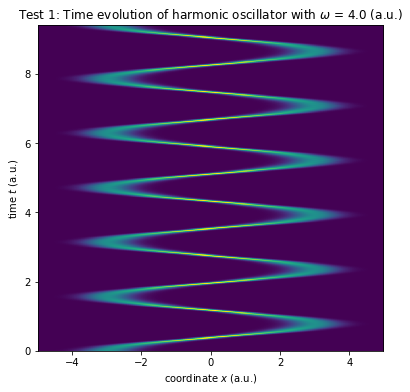


Hamiltonian is preserved within the accuracy of 4.0e-02 percent


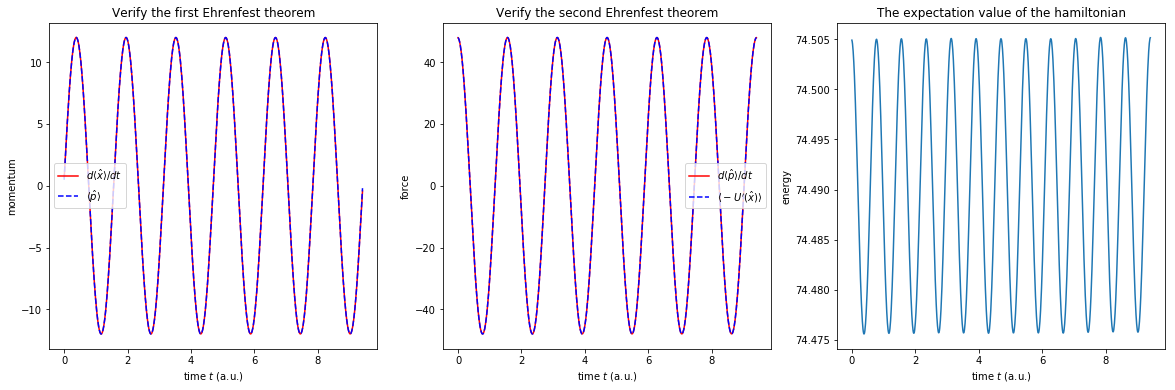

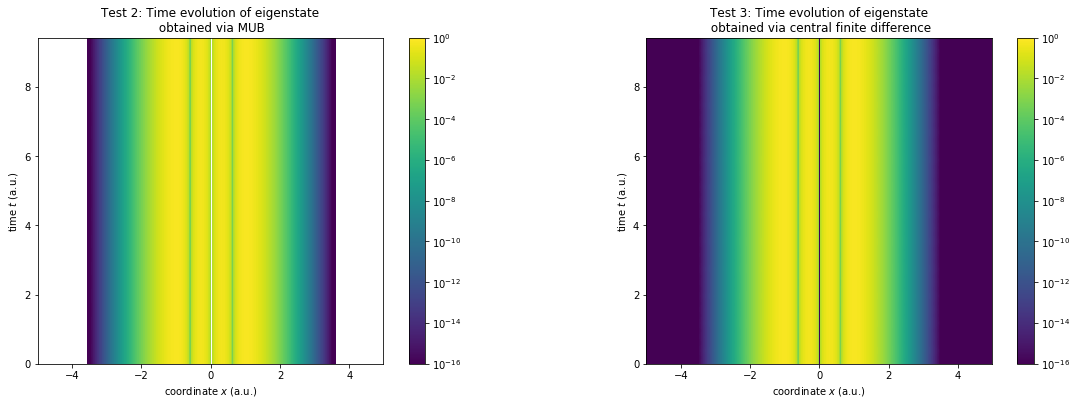

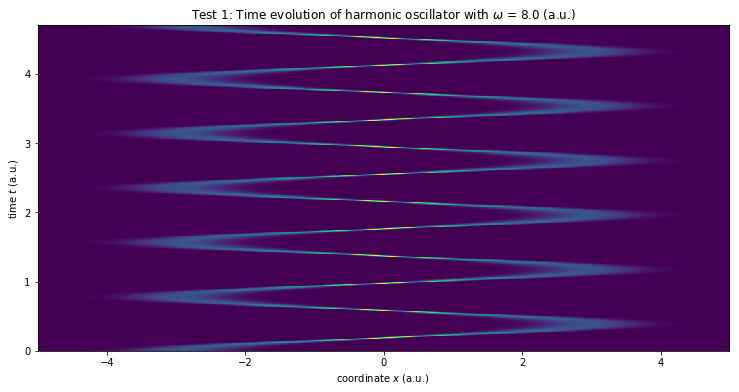


Hamiltonian is preserved within the accuracy of 1.6e-01 percent


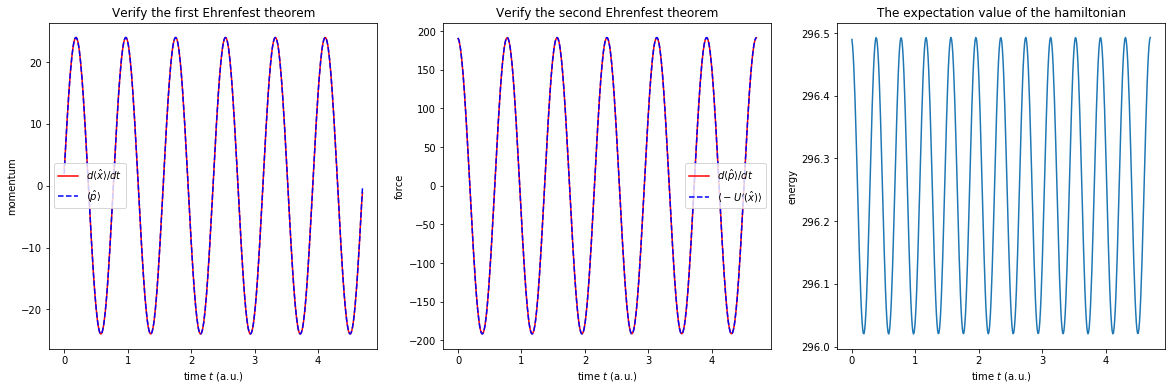

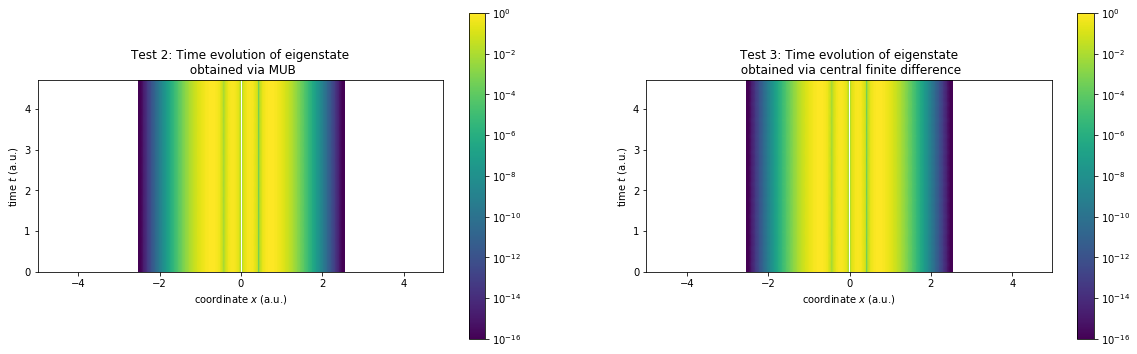

In [3]:
for omega in [4., 8.]:

    @njit
    def v(x, t=0.):
        """
        Potential energy
        """
        return 0.5 * (omega * x) ** 2
    
    @njit
    def diff_v(x, t=0.):
        """
        the derivative of the potential energy for Ehrenfest theorem evaluation
        """
        return (omega) ** 2 * x
    
    @njit
    def k(p, t=0.):
        """
        Non-relativistic kinetic energy
        """
        return 0.5 * p ** 2
    
    @njit
    def diff_k(p, t=0.):
        """
        the derivative of the kinetic energy for Ehrenfest theorem evaluation
        """
        return p
    
    # save parameters as a separate bundle
    harmonic_osc_params = dict(
        x_grid_dim=512,
        x_amplitude=5.,
        v=v,
        k=k,
        
        diff_v=diff_v,
        diff_k=diff_k,
        
        dt=0.01,
    )

    ##################################################################################################

    # create the harmonic oscillator with time-independent hamiltonian
    harmonic_osc = SplitOpSchrodinger1D(**harmonic_osc_params)

    # set the initial condition
    harmonic_osc.set_wavefunction(
        lambda x: np.exp(-(x + 3.) ** 2)
        # The same as
        #   np.exp(-(harmonic_osc.x + 3.) ** 2)
    )

    # get time duration of 6 periods
    T = 6 * 2. * np.pi / omega

    # get number of steps necessary to reach time T
    time_steps = int(round(T / harmonic_osc.dt))

    # propagate till time T and for each time step save a probability density
    wavefunctions = [harmonic_osc.propagate().copy() for _ in range(time_steps)]

    plt.title(
        "Test 1: Time evolution of harmonic oscillator with $\\omega$ = {:.1f} (a.u.)".format(omega)
    )

    # plot the time dependent density
    plt.imshow(
        np.abs(wavefunctions) ** 2,
        # some plotting parameters
        origin='lower',
        extent=[harmonic_osc.x.min(), harmonic_osc.x.max(), 0., time_steps * harmonic_osc.dt]
    )
    plt.xlabel('coordinate $x$ (a.u.)')
    plt.ylabel('time $t$ (a.u.)')
    plt.show()

    ##################################################################################################

    plt.subplot(131)
    plt.title("Verify the first Ehrenfest theorem")

    times = harmonic_osc.dt * np.arange(len(harmonic_osc.x_average))
    plt.plot(
        times,
        np.gradient(harmonic_osc.x_average, harmonic_osc.dt),
        '-r',
        label='$d\\langle\\hat{x}\\rangle / dt$'
    )
    plt.plot(times, harmonic_osc.x_average_rhs, '--b', label='$\\langle\\hat{p}\\rangle$')
    plt.legend()
    plt.ylabel('momentum')
    plt.xlabel('time $t$ (a.u.)')

    plt.subplot(132)
    plt.title("Verify the second Ehrenfest theorem")

    plt.plot(
        times,
        np.gradient(harmonic_osc.p_average, harmonic_osc.dt),
        '-r',
        label='$d\\langle\\hat{p}\\rangle / dt$'
    )
    plt.plot(times, harmonic_osc.p_average_rhs, '--b', label='$\\langle -U\'(\\hat{x})\\rangle$')
    plt.legend()
    plt.ylabel('force')
    plt.xlabel('time $t$ (a.u.)')

    plt.subplot(133)
    plt.title("The expectation value of the hamiltonian")

    # Analyze how well the energy was preserved
    h = np.array(harmonic_osc.hamiltonian_average)
    print(
        "\nHamiltonian is preserved within the accuracy of {:.1e} percent".format(
            100. * (1. - h.min() / h.max())
        )
    )

    plt.plot(times, h)
    plt.ylabel('energy')
    plt.xlabel('time $t$ (a.u.)')

    plt.show()

    ##################################################################################################

    # re-create the harmonic oscillator
    harmonic_osc = SplitOpSchrodinger1D(**harmonic_osc_params)

    # as the second test, let's check that an eigenstate state is a stationary state
    # to find a good ground state let's use the mutually unbiased bases method already implemented
    from mub_qhamiltonian import MUBQHamiltonian
    eigenstate = MUBQHamiltonian(**harmonic_osc_params).get_eigenstate(3)

    # set the initial condition
    harmonic_osc.set_wavefunction(eigenstate)

    plt.subplot(121)
    plt.title("Test 2: Time evolution of eigenstate\n obtained via MUB")

    # enable log color plot
    from matplotlib.colors import LogNorm

    # propagate and plot
    plt.imshow(
        [np.abs(harmonic_osc.propagate()) ** 2 for _ in range(time_steps)],
        # some plotting parameters
        origin='lower',
        extent=[harmonic_osc.x.min(), harmonic_osc.x.max(), 0., time_steps * harmonic_osc.dt],
        norm = LogNorm(1e-16, 1.)
    )
    plt.colorbar()
    plt.xlabel('coordinate $x$ (a.u.)')
    plt.ylabel('time $t$ (a.u.)')

    ##################################################################################################

    # re-create the harmonic oscillator
    harmonic_osc = SplitOpSchrodinger1D(**harmonic_osc_params)

    # let's see what happens if we use an eigenstate generated via the central finite difference method
    from central_diff_qhamiltonian import CentralDiffQHamiltonian
    eigenstate = CentralDiffQHamiltonian(**harmonic_osc_params).get_eigenstate(3)

    # set the initial condition
    harmonic_osc.set_wavefunction(eigenstate)

    plt.subplot(122)
    plt.title("Test 3: Time evolution of eigenstate\n obtained via central finite difference")

    # propagate and plot
    plt.imshow(
        [np.abs(harmonic_osc.propagate()) ** 2 for _ in range(time_steps)],
        # some plotting parameters
        origin='lower',
        extent=[harmonic_osc.x.min(), harmonic_osc.x.max(), 0., time_steps * harmonic_osc.dt],
        norm=LogNorm(1e-16, 1.)
    )
    plt.colorbar()
    plt.xlabel('coordinate $x$ (a.u.)')
    plt.ylabel('time $t$ (a.u.)')

    plt.show()